# Monte Carlo Greeks: Pathwise & Likelihood‐Ratio Methods

We compute the **Delta** and **Vega** of a European vanilla call via:

1. **Pathwise derivative** (exact for differentiable payoffs)  
2. **Likelihood‐ratio (score)** method (works more generally)  

We compare both to the analytic Black–Scholes Greeks and study convergence.

| Symbol    | Meaning                      | Value      |
|-----------|------------------------------|------------|
| \(S_0\)    | Initial stock price          | **100**    |
| \(K\)      | Strike price                | 100        |
| \(r\)      | Risk-free rate (annual)     | 5 %        |
| $(\sigma)$ | Volatility (annual)         | 20 %       |
| \(T\)      | Time to maturity (years)    | 1.0        |
| \(M\)      | MC time steps (for pathwise)| 1 (analytic GBM) |
| $(N_{\rm paths})$ | Number of simulations | 100 000    |
| \(h\)      | Bump size for FD           | 0.01       |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# analytic


def bs_delta(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


def bs_vega(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S0 * norm.pdf(d1) * np.sqrt(T)


# parameters
S0, K, r, sigma, T = 100, 100, 0.05, 0.20, 1.0
N_paths = 100_000

In [2]:
def simulate_gbm_terminal(S0, r, sigma, T, n_paths):
    """
    Simulate terminal stock prices ST and the underlying Z ~ N(0,1).
    """
    Z = np.random.randn(n_paths)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    return ST, Z

In [3]:
# Pathwise Delta
def mc_pathwise_delta(S0, K, r, sigma, T, n_paths):
    ST, Z = simulate_gbm_terminal(S0, r, sigma, T, n_paths)

    # dPayoff/dS0 = I{ST>K} * (ST/S0)
    payoff_deriv = np.where(ST > K, ST / S0, 0.0)
    discounted = np.exp(-r * T) * payoff_deriv

    return discounted.mean()

In [4]:
# Likelihood‐Ratio Greeks


def mc_lr_greeks(S0, K, r, sigma, T, n_paths):
    ST, Z = simulate_gbm_terminal(S0, r, sigma, T, n_paths)
    payoff = np.maximum(ST - K, 0.0)

    # score terms
    lr_delta = payoff * Z / (S0 * sigma * np.sqrt(T))
    lr_vega = payoff * (Z**2 - 1) / sigma
    discount = np.exp(-r * T)

    return discount * lr_delta.mean(), discount * lr_vega.mean()

In [5]:
# analytic
delta_bs = bs_delta(S0, K, r, sigma, T)
vega_bs = bs_vega(S0, K, r, sigma, T)

# MC estimates
delta_pw = mc_pathwise_delta(S0, K, r, sigma, T, N_paths)
delta_lr, vega_lr = mc_lr_greeks(S0, K, r, sigma, T, N_paths)

print(f"Δ delta (analytic)     : {delta_bs : .4f}")
print(f"Δ delta (pathwise MC)  : {delta_pw : .4f}")
print(f"Δ delta (LR MC)        : {delta_lr : .4f}")
print(f"ν vega (analytic)      : {vega_bs  : .4f}")
print(f"ν vega (LR MC)         : {vega_lr  : .4f}")

Δ delta (analytic)     :  0.6368
Δ delta (pathwise MC)  :  0.6371
Δ delta (LR MC)        :  0.6390
ν vega (analytic)      :  37.5240
ν vega (LR MC)         :  51.4404


### Convergence of Monte Carlo Greeks  
Error vs number of paths \(N\), on log–log scale (reference slope $(N^{-1/2})$).

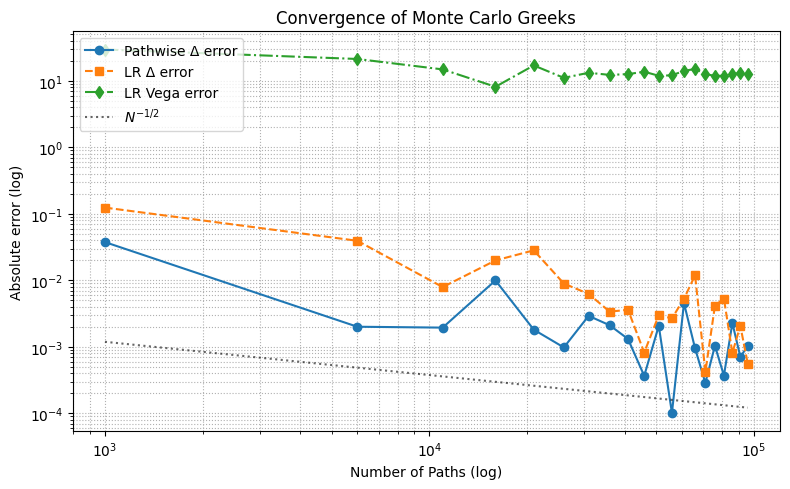

In [6]:
path_sizes = np.arange(1_000, 101_000, 5_000)

pw_errors = []
lr_err_d = []
lr_err_v = []

for n in path_sizes:
    dpw = mc_pathwise_delta(S0, K, r, sigma, T, n)
    dlr, vlr = mc_lr_greeks(S0, K, r, sigma, T, n)
    pw_errors.append(abs(dpw - delta_bs))
    lr_err_d.append(abs(dlr - delta_bs))
    lr_err_v.append(abs(vlr - vega_bs))

plt.figure(figsize=(8, 5))
plt.loglog(path_sizes, pw_errors, "o-", label="Pathwise Δ error")
plt.loglog(path_sizes, lr_err_d, "s--", label="LR Δ error")
plt.loglog(path_sizes, lr_err_v, "d-.", label="LR Vega error")

# reference slopes
plt.loglog(
    path_sizes, path_sizes**-0.5 * pw_errors[0], "k:", alpha=0.6, label=r"$N^{-1/2}$"
)

plt.xlabel("Number of Paths (log)")
plt.ylabel("Absolute error (log)")
plt.title("Convergence of Monte Carlo Greeks")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()

# save the plot into plots folder
plt.savefig("../../plots/MC_Greek_Convergence.png", dpi=300)

plt.show()

### Observations  
- All MC‐Greek estimators converge at the expected $(O(N^{-1/2}))$ rate.  
- Pathwise Δ matches analytic but can’t compute Vega.  
- LR method yields both Δ and ν in one go, with similar convergence.

### Summary  
We’ve implemented two unbiased MC approaches for Greeks and shown both  
converge to their Black–Scholes values at the theoretical sampling rate.